<a href="https://colab.research.google.com/github/samanmunikar/TensorFlow/blob/master/Predicting_Stock_Price_using_TensorFlow2_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# pip install tensorflow==2.0
pip install tensorflow-gpu==2.0

In [47]:
import tensorflow 
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

1.15.0
Num GPUs Available:  1


In [48]:
pip install yahoo_fin

In [49]:
pip install requests_html

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os

In [0]:
# Preparing the Dataset
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, test_size=0.2,
              feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
  #see if ticker is already a loaded stock from yahoo finance
  if isinstance(ticker, str):
    #load it from yahoo_fin library
    df = si.get_data(ticker)
  elif isinstance(ticker, pd.DataFrame):
    df = ticker

  # this will contain all the elements we want to return from this function
  result = {}
  #we will also return original dataframe from this function
  result['df'] = df.copy()
  # check column passed is in the dataframe itself
  for column in feature_columns:
    assert column in df.columns

  if scale:
    column_scaler = {}
    # scale the data(prices) from 0 to 1
    for column in feature_columns:
      scalar = preprocessing.MinMaxScaler()
      df[column] = scalar.fit_transform(np.expand_dims(df[column].values, axis=1))
      column_scaler[column] = scalar

    # add the MinMaxScalar instances to the result returned
    result['column_scaler'] = column_scaler

  # add the target column(label) by shifting by lookup_step
  df['future'] = df['adjclose'].shift(-lookup_step)

  # last lookup_state columns contains NaN in future column
  # get them before dropping NaN
  last_sequence = np.array(df[feature_columns].tail(lookup_step))

  #drop NaNs
  df.dropna(inplace=True)

  sequence_data = []
  sequences = deque(maxlen=n_steps)
  for entry, target in zip(df[feature_columns].values, df['future'].values):
    sequences.append(entry)
    if len(sequences) == n_steps:
      sequence_data.append([np.array(sequences), target])

  # get the last sequence by appending the last 'n_step' sequence with 'lookup_step' sequence
  # for instance, if n_steps = 50 and lookup_step=10, last_sequence should beof 59(50+10-1) length
  # this last_sequence will be used to predict in future dates that are not available in the dataset
  last_sequence = list(sequences) + list(last_sequence)
  # shift the last sequence by -1
  last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
  # add to result
  result['last_sequence'] = last_sequence
  # construct the X's and Y's
  X, y = [], []

  for seq, target in sequence_data:
    X.append(seq)
    y.append(target)

  # convert to numpy array
  X = np.array(X)
  y = np.array(y)

  # reshape X to fit the neural network
  X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))

  # split the dataset
  result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X,y,test_size= test_size, shuffle=shuffle)

  # return the result
  return result


In [0]:
# Model Creation

def create_model(input_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                 loss="mean_absolute_error", optimizer="rmsprop"):
  model = Sequential()
  for i in range(n_layers):
    if i==0:
      #First layer
      model.add(cell(units, return_sequences=True, input_shape=(None, input_length)))
    elif i == n_layers - 1:
      # Last layer
      model.add(cell(units, return_sequences=False))
    else:
      # hidden layer
      model.add(cell(units, return_sequences=True))

    # add dropout after each layer
    model.add(Dropout(dropout))

  model.add(Dense(1, activation="linear"))
  model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)

  return model

In [0]:
# Training the model
# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
### training parameters
# mean squared error loss
LOSS = "mse"
OPTIMIZER = "rmsprop"
BATCH_SIZE = 64
EPOCHS = 10
# Apple stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save
model_name = f"{date_now}_{ticker}-{LOSS}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

In [0]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [0]:
# load the CSV file from disk (dataset) if it already exists (without downloading)
if os.path.isfile(ticker_data_filename):
    ticker = pd.read_csv(ticker_data_filename)

In [56]:
# load the data

data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
if not os.path.isfile(ticker_data_filename):
  # save the CSV file(dataset)
  data["df"] .to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS, dropout=DROPOUT, optimizer=OPTIMIZER)

#some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name), save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Train on 7861 samples, validate on 1966 samples
Epoch 1/10
7808/7861 [============================>.] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0278
Epoch 00001: val_loss improved from inf to 0.00080, saving model to results/2020-02-19_AAPL-mse-LSTM-seq-50-step-1-layers-3-units-256
7861/7861 [==============================] - 7s 929us/sample - loss: 0.0040 - mean_absolute_error: 0.0278 - val_loss: 8.0063e-04 - val_mean_absolute_error: 0.0186
Epoch 2/10
7744/7861 [============================>.] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0205
Epoch 00002: val_loss did not improve from 0.00080
7861/7861 [==============================] - 4s 488us/sample - loss: 0.0020 - mean_absolute_error: 0.0207 - val_loss: 0.0022 - val_mean_absolute_error: 0.0213
Epoch 3/10
7744/7861 [============================>.] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0187
Epoch 00003: val_loss did not improve from 0.00080
7861/7861 [==============================] - 4s 484us/sample - loss

In [0]:
 # !tensorboard --logdir="logs" --bind_all

In [58]:
# evaluate the model
mse, mae = model.evaluate(data["X_test"], data["y_test"])
# calculate the mean absolute error (inverse scaling)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform(mae.reshape(1,-1))[0][0]
print("Mean Absolute Error : ", mean_absolute_error)

1966/1966 [==============================] - 1s 257us/sample - loss: 2.8829e-04 - mean_absolute_error: 0.0148
Mean Absolute Error :  4.9969025


In [59]:
data

{'X_test': array([[[1.40604500e-04, 6.51147697e-03, 1.71945996e-04, ...,
          1.51312421e-04, 1.56688762e-04, 1.58869612e-04],
         [8.65257723e-05, 1.19241233e-02, 1.10045410e-04, ...,
          1.23801080e-04, 1.29438554e-04, 1.31240127e-04],
         [1.40604500e-04, 6.24582561e-03, 1.71945996e-04, ...,
          3.30136229e-04, 3.33815156e-04, 3.38461362e-04],
         [3.02840773e-04, 1.87555894e-02, 3.78281099e-04, ...,
          4.26425968e-04, 4.29190928e-04, 4.35164608e-04],
         [3.35288091e-04, 9.48194212e-03, 4.26425968e-04, ...,
          3.98914628e-04, 4.08753341e-04, 4.07535123e-04]],
 
        [[9.90391918e-03, 6.83652253e-02, 1.12617727e-02, ...,
          1.30995306e-02, 1.30078929e-02, 1.28863988e-02],
         [1.16670631e-02, 1.87244207e-01, 1.29652751e-02, ...,
          1.32712025e-02, 1.34395361e-02, 1.31074339e-02],
         [1.16556862e-02, 9.97422729e-02, 1.32117781e-02, ...,
          1.33988552e-02, 1.34242757e-02, 1.34058334e-02],
         [1

In [0]:
# Predict 
def predict(model, data, classification=False):
  # retrieve the last sequence from data
  last_sequence = data["last_sequence"][:N_STEPS]
  # retrieve the column scalars
  column_scaler = data["column_scaler"]
  # reshape the last sequence
  last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
  # expand dims
  last_sequence = np.expand_dims(last_sequence, axis=0)
  # get the prediction (scaled 0 to 1)
  prediction = model.predict(last_sequence)
  # get the price(by inverting the scaling)
  predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
  return predicted_price

In [0]:
# last_seq = data["last_sequence"][:N_STEPS]
# column_scaler = data["column_scaler"]
# last_seq = last_seq.reshape((last_seq.shape[1], last_seq.shape[0]))
# last_seq = np.expand_dims(last_seq, axis=0)
# pred = model.predict(last_seq)
# print(pred)
# print(column_scaler["adjclose"].inverse_transform(pred))

In [62]:
# predict the future price
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price: .2f}$")

Future price after 1 days is  299.64$


In [0]:
# plot the graph
def plot_graph(model, data):
  y_test = data["y_test"]
  X_test = data["X_test"]
  y_pred = model.predict(X_test)
  y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test,axis=0)))
  y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
  plt.plot(y_test[-200:], c='b')
  plt.plot(y_pred[-200:], c='r')
  plt.xlabel("Days")
  plt.ylabel("Price")
  plt.legend(["Acutal Price", "Predicted Price"])
  plt.show()

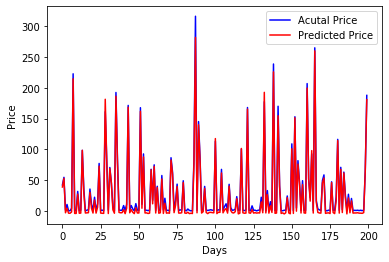

In [64]:
plot_graph(model, data)

In [0]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

In [66]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.7862595419847328
